# Introduction

This simple weather generator is built on a two-state Markov Chain comprising of the states sunny (S) and rainy (R). Let $X_n$ be the state of the weather for day $n$. We use the following probabilities:

$$\mathbb{P}(X_{n+1}=R|X_n=S) = \alpha$$ and $$\mathbb{P}(X_{n+1}=S|X_n=R) = \beta,$$

where $\alpha, \beta \in [0,1]$ are taken to be fixed arbitrary probabilities.

State 0 corresponds Sunny, State 1 corresponds to Rainy

In [1]:
import numpy as np
from random import random
import matplotlib.pyplot as plt
import scipy.linalg

/Users/owencray/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Functions 

### Model + Posterior

In [2]:
def random_walk(a, b, n, start_state):
    '''
    Generates a random walk of length n, starting at 
    start_state, given the transition probabilites a, b.
    '''
    #Transition Matrix
    P = np.array([[1-a, a], [b, 1-b]])

    # Perform Random Walk
    walk = []

    walk.append(start_state)
    prev_state = start_state

    while n-1:
        curr_state = np.random.choice([0, 1], p = P[prev_state])
        walk.append(curr_state)
        prev_state = curr_state
        n -= 1
    
    return walk


def stat_dist(a, b):
    '''
    Returns the transition matrix and stationary distribution probabilities
    for being in Sunny or Rain states
    '''
    #Transition Matrix
    P = np.array([[1-a, a], [b, 1-b]])

    # Find stationary probabilities
    values, left = scipy.linalg.eig(P, right = False, left = True)

    if values[0] == 1:
        pi = left[:, 0]
        pass
    else:
        pi = left[:, 1]

    pi_normalised = [(x/np.sum(pi)).real for x in pi]

    p_s = pi_normalised[0]
    p_r = pi_normalised[1]
    
    return P, p_s, p_r


def log_post(walk, a, b):
    '''
    Returns the value of the posterior function
    given a random walk (walk) that was sampled 
    using the transition probabilities a, b.
    '''
    # Transition matrix
    A = 1-a
    B = 1-b
    
    p_s = b/(a+b)
    p_r = a/(a+b)
   
    # Log-likelihood
    lh = np.log((1-walk[0])*p_s + (walk[0])*p_r)
    for i in range(len(walk)-1):
        u_0 = 1 - walk[i]
        u_1 = 1 - walk[i+1]
        lh += u_0*u_1*np.log(A) + u_0*(1-u_1)*np.log(a) + (1-u_0)*u_1*np.log(b) + (1-u_0)*(1-u_1)*np.log(B)
                
    return lh             


def log_partial_post(walk, a, b, n):
    '''
    Returns the value of the posterior function
    given a random walk (walk) that was sampled 
    using the transition probabilities a, b, with 
    data only at n intervals.
    '''
    # Transition matrix
    P = np.array([[1-a, a], [b, 1-b]])
    P = np.linalg.matrix_power(P, n)   # Transition matrix for moving from state i to j in n steps
    
    walk = np.array(walk)[np.s_[0::n]] # Keeps every multiple of n, discards the rest
    
    p_s = b/(a+b)
    p_r = a/(a+b)
   
    # Log-likelihood
    lh = np.log((1-walk[0])*p_s + (walk[0])*p_r)
    for i in range(len(walk)-1):
        u_0 = 1 - walk[i]
        u_1 = 1 - walk[i+1]
        lh += u_0*u_1*np.log(P[0][0]) + u_0*(1-u_1)*np.log(P[0][1]) +(1-u_0)*u_1*np.log(P[1][0]) + (1-u_0)*(1-u_1)*np.log(P[1][1])
                    
    return lh


def changing_random_walk(a, b, n, start_state, a_new, b_new):
    '''
    Generates a random walk of length n, starting at 
    start_state, given the transition probabilites a, b.
    a_new and b_new are the values of a and ab at the end of n days.
    '''
    #Transition Matrix
    P = np.array([[1-a, a], [b, 1-b]])

    # Perform Random Walk
    walk = []

    walk.append(start_state)
    prev_state = start_state
    
    da = (a_new - a)/n
    db = (b_new - b)/n

    while n-1:
        curr_state = np.random.choice([0, 1], p = P[prev_state])
        walk.append(curr_state)
        prev_state = curr_state
        n -= 1
        a += da
        b += db
        P = np.array([[1-a, a], [b, 1-b]])
    
    return walk

### $k$ rainy days in $N$ days functions

In [3]:
def logfactorial(n):
    result = 0
    for i in range(1, int(n+1)):
        result = result + np.log(i)
        
    return result


def logcombination(n, m):
    
    return logfactorial(n) - logfactorial(n-m) - logfactorial(m)


def prob_1(a, b, N, k):
    
    result = 0
    for j in range(1, min(2*(N-k), 2*k-1)+1):
        sup = np.floor(j/2)
        sdown = np.floor((j+1)/2)
        s1 = k - sdown - 1 + (j % 2)
        s0 = N - k - sup - (j % 2)
        logelement = logcombination(k-1, sup) + logcombination(N-k-1, sdown-1) + (s1 * np.log(1-b)) + \
        (sdown * np.log(b)) + (s0 * np.log(1-a)) + (sup * np.log(a))
        result += np.exp(logelement)
        
    return result

def prob_0(a, b, N, k):
    return prob_1(b, a, N, N-k)

### Extreme Events

In [5]:
def consecutive_days(walk, state):
    '''
    Takes a random walk and returns a list of indices
    for consecutive days in a chosen state.
    Inputs:
    - walk: a random weather walk
    - state: find consecutive days of this state (sunny:0, rain:1)
    '''
    # Finding the indices of the days in the chosen state (Segregating the 'state' days)
    lst = []
    N = len(walk)

    for i in range(N):
        if walk[i] == state:
            lst.append(i)

    # Finding consecutive days of 'state'
    grouped = [[lst[0]]]

    for x in lst[1:]:
        # check indices and group consecutive days
        if x == grouped[-1][-1] + 1:
            grouped[-1].append(x)
        else:
            grouped.append([x])
    return grouped


def find_list(lis, length):
    '''
    Returns the indices of the lists with length n
    '''
    list_len = [len(i) for i in lis]
    ind = []
    
    i = 0
    while i < len(lis):
        if len(lis[i]) >= length:
            ind.append(i)
            i += 1
        else:
            i += 1
    return ind
  
    
def f(a, length, ps):
    return ps * (a**(length-1))


def f_p(a, length, ps):
     return ps * (length - 1) * (a**(length-2))


def rate(a1, a2, length, ps):
    da = a2 - a1
    rate = (f(1-a2, length, ps)-f(1-a1, length, ps))/f(1-a1, length, ps)
    return rate


def rate_approx(a1, a2, length, ps):
    da = a2 - a1
    approx = f_p(1-a1, length, ps)*-da/f(1-a1, length, ps)
    return approx


def emp_extreme_rate(length, a1, a2, b, N):
    '''
    Returns the empirical rate of change in the probability 
    of observing at least 'length' consecutive sunny days 
    when 'beta' is b and 'alpha' changes from a1 to a2.
    '''
    prob_a1_list = []
    prob_a2_list = []

    P1, ps1, pr1 = stat_dist(a1, b)
    P2, ps2, pr2 = stat_dist(a1, b)

    for i in range(500):
        ds_1 = 0
        ds_2 = 0
        for i in range(N):
            start1 =  np.random.choice([0, 1], p = np.array([ps1, pr1]))
            start2 =  np.random.choice([0, 1], p = np.array([ps2, pr2]))
            sample_walk1 = random_walk(a1, b, length, start1)
            sample_walk2 = random_walk(a2, b, length, start2)
            
            if sample_walk1 == np.repeat(0, length).tolist():
                ds_1 += 1
            else:
                ds_1 = ds_1
                
            if sample_walk2 == np.repeat(0, length).tolist():
                ds_2 += 1
            else:
                ds_2 = ds_2
        prob_a1_list.append(ds_1/N)
        prob_a2_list.append(ds_2/N)           
        
        rate = (np.mean(prob_a2_list) - np.mean(prob_a1_list))/np.mean(prob_a1_list)
        
    return rate


def emp_extreme_prob(length, a1, a2, b, N):
    '''
    Returns the empirical rate of change in the probability 
    of observing at least 'length' consecutive sunny days 
    when 'beta' is b and 'alpha' changes from a1 to a2.
    '''
    prob_a1_list = []
    prob_a2_list = []

    P1, ps1, pr1 = stat_dist(a1, b)
    P2, ps2, pr2 = stat_dist(a1, b)

    for i in range(500):
        ds_1 = 0
        ds_2 = 0
        for i in range(N):
            start1 =  np.random.choice([0, 1], p = np.array([ps1, pr1]))
            start2 =  np.random.choice([0, 1], p = np.array([ps2, pr2]))
            sample_walk1 = random_walk(a1, b, length, start1)
            sample_walk2 = random_walk(a2, b, length, start2)
            
            if sample_walk1 == np.repeat(0, length).tolist():
                ds_1 += 1
            else:
                ds_1 = ds_1
                
            if sample_walk2 == np.repeat(0, length).tolist():
                ds_2 += 1
            else:
                ds_2 = ds_2
        prob_a1_list.append(ds_1/N)
        prob_a2_list.append(ds_2/N)           
        
        change_prob = (np.mean(prob_a2_list) - np.mean(prob_a1_list))
        
    return change_prob

# Chapter 2: Model

## Stationary distribution as a function of $\alpha$ and $\beta$

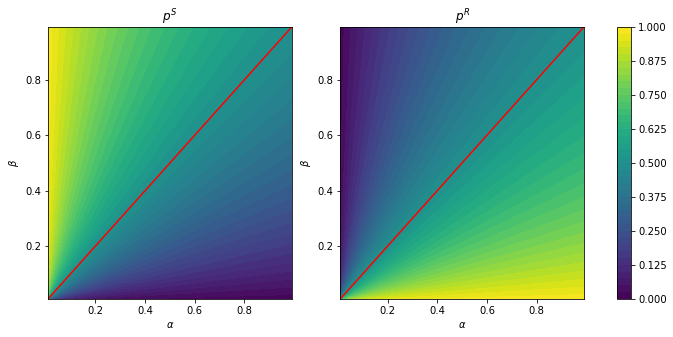

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
 
M = np.zeros((100, 100))
    
# defining all 3 axis
alpha = np.linspace(0.01, 0.99, 100)
beta = np.linspace(0.01, 0.99, 100)
A, B = np.meshgrid(alpha, beta)
ps = B / (A + B)
pr = A / (A + B)
 
# plotting
ax_0 = ax[0].contourf(A, B, ps, 40)
ax[0].plot(np.linspace(0.01, 0.99, 200), np.linspace(0.01, 0.99, 200), 'r')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel(r'$\beta$')
ax[0].set_title(r'$p^S$')

ax[1].contourf(A, B, pr, 40)
ax[1].plot(np.linspace(0.01, 0.99, 200), np.linspace(0.01, 0.99, 200), 'r')
ax[1].set_xlabel(r'$\alpha$')
ax[1].set_ylabel(r'$\beta$')
ax[1].set_title(r'$p^R$')
fig.colorbar(ax_0, ax=ax)
plt.show()

# Chapter 3.1 Full Information 

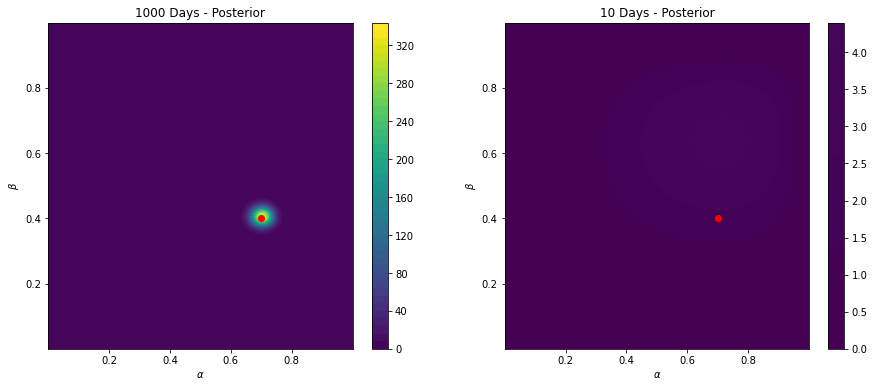

In [41]:
# Posterior over the full information 

a_star = 0.7
b_star = 0.4

# Data
n = 100
alpha_list = np.linspace(0.000001, 0.999999, n)
beta_list = np.linspace(0.000001, 0.999999, n)

# 500 days
walk = random_walk(a_star, b_star, 1000, 0)

log_weather_500 = np.zeros((n,n), dtype = float)

for i in range(n):
    for j in range(n):
        log_weather_500[j][i] = log_post(walk, alpha_list[i], beta_list[j])

#100 days
walk = random_walk(a_star, b_star, 10, 0)

log_weather_100 = np.zeros((n,n), dtype = float)

for i in range(n):
    for j in range(n):
        log_weather_100[j][i] = log_post(walk, alpha_list[i], beta_list[j])

# Exponentiating
weather_100 = np.exp(log_weather_100)
weather_500 = np.exp(log_weather_500)

# Normalising
norm_weather_100 = weather_100/(np.sum(weather_100)*(alpha_list[1]-alpha_list[0])**2)
norm_weather_500 = weather_500/(np.sum(weather_500)*(alpha_list[1]-alpha_list[0])**2)

# Plotting        
fig, ax = plt.subplots(ncols = 2, figsize = (15, 6))
minimum = min(np.min(norm_weather_500), np.min(norm_weather_100))
maximum = max(np.max(norm_weather_500), np.max(norm_weather_100))
        
c0 = ax[0].contourf(alpha_list, beta_list, norm_weather_500, levels = 50, vmin = minimum, vmax = maximum)
ax[0].set_title('1000 Days - Posterior')
ax[0].set_xlabel(r"$\alpha$")
ax[0].set_ylabel(r"$\beta$")
ax[0].plot(a_star, b_star, 'ro')
fig.colorbar(c0, ax=ax[0])

c1 = ax[1].contourf(alpha_list, beta_list, norm_weather_100, levels = 50, vmin = minimum, vmax = maximum)
ax[1].set_title('10 Days - Posterior')
ax[1].set_xlabel(r"$\alpha$")
ax[1].set_ylabel(r"$\beta$")
ax[1].plot(a_star, b_star, 'ro')
fig.colorbar(c1, ax=ax[1])
plt.show()

# Chapter 4 Uncertainty on the stationary probabilites

0.7909090909090909


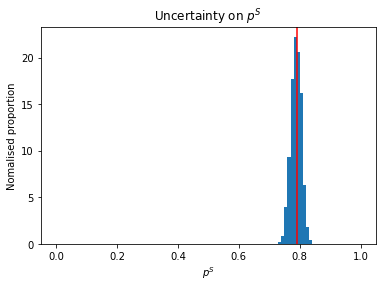

In [48]:
# Probabilities of probabilities

n = 100
alpha_list = np.linspace(0.000001, 0.999999, n)
beta_list = np.linspace(0.000001, 0.999999, n)

a_star = 0.23
b_star = 0.87

def ps(a, b):
    p_s = b/(a+b)
    return p_s

log_weather = np.zeros((n,n))
p_s = np.zeros((n, n))
walk = random_walk(a_star, b_star, 500, 0)

for i in range(n):
    for j in range(n):
        p_s[i,j] = ps(alpha_list[i], beta_list[j])
        log_weather[i,j] = log_post(walk, alpha_list[i], beta_list[j])
        
# Histogram
plt.hist(p_s.ravel(), density = True, weights = np.exp(log_weather).ravel(), bins = 100)


# plt.stairs(counts, bins)
plt.xlabel(r'$p^S$')
plt.ylabel('Nomalised proportion')
plt.title(r'Uncertainty on $p^S$')

# True value
P, p_s_star, p_r = stat_dist(a_star, b_star)

print(p_s_star)
plt.axvline(p_s_star, color = 'red')
plt.show()

# Chapter 5.1 Full Information vs Partial Information

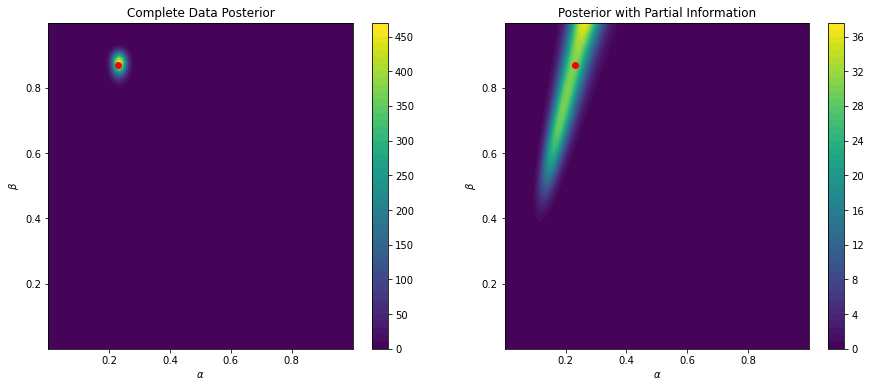

In [7]:
# Posterior over the full information vs data at 3 day intervals 

# Data
n = 100
a_star = 0.23
b_star = 0.87
alpha_list = np.linspace(0.000001, 0.999999, n)
beta_list = np.linspace(0.000001, 0.999999, n)

# Full information
walk = random_walk(a_star, b_star, 1000, 0)

log_weather = np.zeros((n,n), dtype = float)

for i in range(n):
    for j in range(n):
        log_weather[j][i] = log_post(walk, alpha_list[i], beta_list[j])


# Partial information
log_weather_p = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        log_weather_p[j][i] = log_partial_post(walk, alpha_list[i], beta_list[j], 3)
        
# Exponentiating
weather = np.exp(log_weather)
weather_p = np.exp(log_weather_p)

# Normalising
norm_weather = weather/(np.sum(weather)*(alpha_list[1]-alpha_list[0])**2)
norm_weather_p = weather_p/(np.sum(weather_p)*(alpha_list[1]-alpha_list[0])**2)

# Plotting        
fig, ax = plt.subplots(ncols = 2, figsize = (15, 6))
minimum = min(np.min(norm_weather), np.min(norm_weather_p))
maximum = max(np.max(norm_weather), np.max(norm_weather_p))
        
c0 = ax[0].contourf(alpha_list, beta_list, norm_weather, levels = 50, vmin = minimum, vmax = maximum)
ax[0].set_title('Complete Data Posterior')
ax[0].set_xlabel(r"$\alpha$")
ax[0].set_ylabel(r"$\beta$")
ax[0].plot(a_star, b_star, 'ro')
fig.colorbar(c0, ax=ax[0])

c1 = ax[1].contourf(alpha_list, beta_list, norm_weather_p, levels = 50)#, vmin = minimum, vmax = maximum)
ax[1].set_title('Posterior with Partial Information')
ax[1].set_xlabel(r"$\alpha$")
ax[1].set_ylabel(r"$\beta$")
ax[1].plot(a_star, b_star, 'ro')
fig.colorbar(c1, ax=ax[1])
None

# Chapter 5.2 $k$ rainy days in $N$ days, given we start in rain

## Testing Formula Validity

In [ ]:
# Testing the formula prob_0, constant alpha and beta

N = 50
alpha, beta = 0.5, 0.5

prob_e = []
prob_t = []
rel_error = np.zeros(N)
error = np.zeros(N)

# Probability
for k in range(N):
    prob = prob_0(alpha, beta, N, k)
    prob_t.append(prob)

    n = 10000
    count = 0

    for i in range(n):
        walk = random_walk(alpha, beta, N, 0)
        if sum(walk) == k:
            count += 1

    prob_emp = count/n
    prob_e.append(prob_emp)
    
# Relative Error
for i in range(N):
    error[i] = abs(prob_e[i]-prob_t[i])
    if prob_e[i] and prob_t[i] >= 1e-50:
        x = (prob_e[i] - prob_t[i])/prob_t[i]
        rel_error[i] = (abs(x))
    else: 
        rel_error[i] = 0

# Plotting
K = np.arange(0, N, 1)

fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (15, 6))

ax[0].plot(K, prob_e, label = 'Empirical probability')
ax[0].plot(K, prob_t, label = 'Theoretical probability')
ax[0].set_xlabel(r'$k$')
ax[0].set_ylabel(r'Probability')
ax[0].set_title(r'Probability of $k$ Rainy Days in 50 Days')
ax[0].legend()

ax[1].plot(K, rel_error, label = '1000 random walks')
ax[1].set_xlabel(r'$k$')
ax[1].set_ylabel(r'% Relative Error')
ax[1].set_title(r'Relative Error of Empirical vs Theoretical Probability')
ax[1].set_ylim((0,10))
ax[1].legend()
plt.show()

In [ ]:
# Testing prob_0 with changing alpha
N = 50

a_list = np.linspace(0.000001, 0.999999, N)
b = 0.5

rel_error = np.zeros((N, N))

for u, v in enumerate(a_list):
    for k in range(N):
        prob = prob_0(v, b, N, k)

        n = 10000
        count = 0

        for j in range(n):
            walk = random_walk(v, b, N, 0)
            if sum(walk) == k:
                count += 1

        prob_emp = count/n
        
        if prob != 0:
            rel_error[u][k] = np.abs((prob_emp - prob)/prob)
        else:
            rel_error[u][k] = np.abs((prob_emp - prob)/1e-300)
    
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (7.5, 6))

K = np.arange(0, N-1, 1)

c0 = ax.contourf(a_list[1:], K, rel_error[1:,1:], levels = 50) # posterior calculated in full vs partial inf
ax.set_title(r'Relative Error for Varying $\alpha$')
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$k$")
fig.colorbar(c0, ax = ax)
plt.show()

## Inferring $\alpha$ and $\beta$

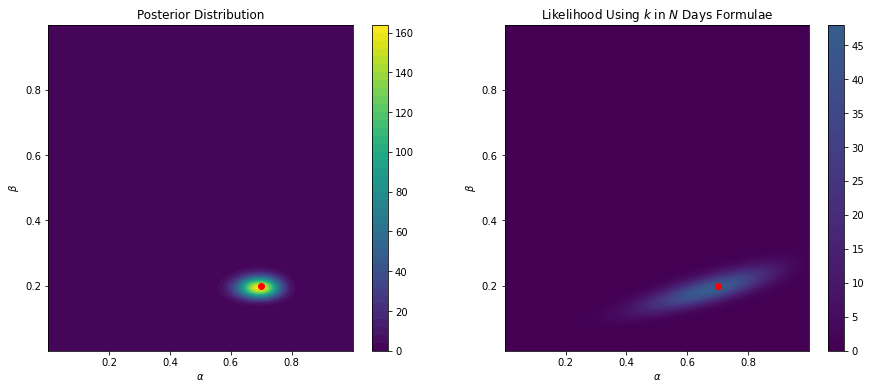

In [55]:
# Infer alpha and beta from chopping long series of data

# Data
m, n = 15, 100
alpha_list = np.linspace(0.000001, 0.999999, n)
beta_list = np.linspace(0.000001, 0.999999, n)
a_star = 0.7
b_star = 0.2

months = []
r_in_month = []

year = random_walk(a_star, b_star, m*30, 1)

# Likehlihood for full data

log_weather = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        log_weather[j][i] = log_post(year, alpha_list[i], beta_list[j])
        
weather = np.exp(log_weather)
norm_weather = weather/(np.sum(weather)*(alpha_list[1]-alpha_list[0])**2)

        
# Chopping the data
for i in range(m):
    month = year[(i)*30:(i+1)*30]
    months.append(month)
    r_in_month.append(np.sum(month))

# Approximating
p_r_approx = np.sum(r_in_month)/(m*30)
p_s_approx = 1 - p_r_approx

# Implementing the formulae
log_like = np.zeros((n,n))

for i, a in enumerate(alpha_list):
    for j, b in enumerate(beta_list):
        likelihood = 0
        for k in r_in_month:
            infer = prob_1(a, b, 30, k)*p_r_approx + prob_0(a, b, 30, k)*p_s_approx
            likelihood += np.log(infer)
        log_like[j][i] = likelihood
        
# Normalising
like = np.exp(log_like)
norm_like = like/(np.sum(like)*(alpha_list[1]-alpha_list[0])**2)


# Plotting
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (15, 6))
minimum = min(np.min(norm_weather), np.min(norm_weather_p))
maximum = max(np.max(norm_weather), np.max(norm_weather_p))

c0 = ax[0].contourf(alpha_list, beta_list, norm_weather, levels = 50, vmin = minimum, vmax = maximum)
ax[0].set_title('Posterior Distribution')
ax[0].set_xlabel(r"$\alpha$")
ax[0].set_ylabel(r"$\beta$")
ax[0].plot(a_star, b_star, 'ro')
fig.colorbar(c0, ax=ax[0])

c1 = ax[1].contourf(alpha_list, beta_list, norm_like, levels = 100, vmin = minimum, vmax = maximum)
ax[1].plot(a_star, b_star, 'ro')
ax[1].set_xlabel(r'$\alpha$')
ax[1].set_ylabel(r'$\beta$')
ax[1].set_title(r'Likelihood Using $k$ in $N$ Days Formulae')
fig.colorbar(c1, ax=ax[1])
plt.show()

# Chapter 6.1 Changes in $\alpha$ and $\beta$ 

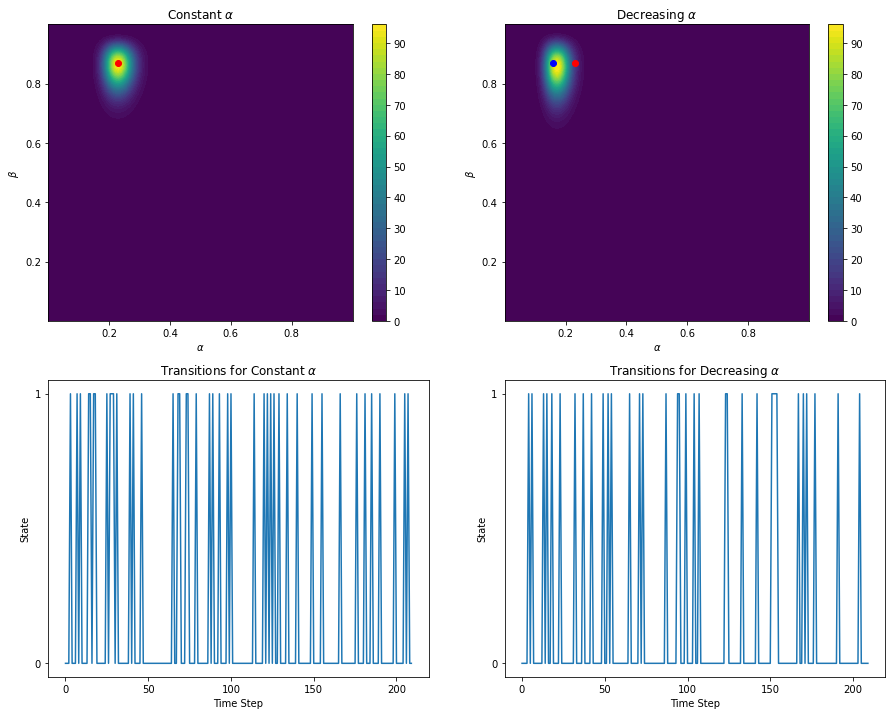

In [19]:
# Chaning alpha (context: more sunny days)

N = 7   # months
n = 100 # accuracy

a_star = 0.23
b_star = 0.87
alpha_list = np.linspace(0.0001, 0.9999, N*30)
beta_list = np.linspace(0.0001, 0.9999, N*30)

# Constant a, b
log_weather = np.zeros((N*30, N*30))
walk = random_walk(a_star, b_star, N*30, 0)

for i in range(N*30):
    for j in range(N*30):
        log_weather[j][i] = log_post(walk, alpha_list[i], beta_list[j])
        
# Changing a
log_weather_p = np.zeros((N*30, N*30))
start_state = 0
walk_p = []
a_new = a_star

for i in range(N):
    a_new -= 0.01
    walk_t = random_walk(a_new, b_star, 30, start_state)
    walk_p += walk_t
    if walk_t[-1] == 0:
        start_state = 0
    else:
        start_state = 1

for i in range(N*30):
    for j in range(N*30):
        log_weather_p[j][i] = log_post(walk_p, alpha_list[i], beta_list[j])
        
# Exponentiating and Normalising
weather = np.exp(log_weather)
weather_p = np.exp(log_weather_p)
norm_weather = weather / (np.sum(weather)*(alpha_list[1]-alpha_list[0])**2)
norm_weather_p = weather_p / (np.sum(weather_p)*(alpha_list[1]-alpha_list[0])**2)
    
        
# Plotting
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 12))
minimum = min(np.min(norm_weather), np.min(norm_weather_p))
maximum = max(np.max(norm_weather), np.max(norm_weather_p))
        
c0 = ax[0][0].contourf(alpha_list, beta_list, norm_weather, levels = 50, vmin = minimum, vmax = maximum)
ax[0][0].set_title(r'Constant $\alpha$')
ax[0][0].set_xlabel(r"$\alpha$")
ax[0][0].set_ylabel(r"$\beta$")
ax[0][0].plot(a_star, b_star, 'ro')
ax[1][0].plot(walk)
ax[1][0].set_xlabel("Time Step")
ax[1][0].set_ylabel("State")
ax[1][0].set_title(r"Transitions for Constant $\alpha$")
ax[1][0].yaxis.set_ticks([0,1])
fig.colorbar(c0, ax=ax[0][0])
        
c1 = ax[0][1].contourf(alpha_list, beta_list, norm_weather_p, levels = 50, vmin = minimum, vmax = maximum)
ax[0][1].set_title(r'Decreasing $\alpha$')
ax[0][1].set_xlabel(r"$\alpha$")
ax[0][1].set_ylabel(r"$\beta$")
ax[0][1].plot(a_star, b_star, 'ro-')
ax[0][1].plot(a_new, b_star, 'bo-')
ax[0][1].arrow(a_star, b_star, a_new-a_star+0.013, 0, head_width=0.03, head_length=0.02, linewidth=1, color='m', length_includes_head=True)
fig.colorbar(c1, ax=ax[0][1])
ax[1][1].plot(walk_p)
ax[1][1].set_xlabel("Time Step")
ax[1][1].set_ylabel("State")
ax[1][1].yaxis.set_ticks([0,1])
ax[1][1].set_title(r"Transitions for Decreasing $\alpha$")
None

# Chapter 6.2 Extreme events

## Empirical Argument

In [ ]:
# Empirical extreme events
# Set parameters
a_1 = 0.3
a_2 = 0.29
b_star = 0.6
n = 10000

# Generate random walks
walk_1 = random_walk(a_1, b_star, n, 0)
walk_2 = random_walk(a_2, b_star, n, 0)

In [ ]:
# Empirical mean of number of sunny days (state 0)
E_sun1 = (n - sum(walk_1))/n
E_sun2 = (n - sum(walk_2))/n
change_E = E_sun2 - E_sun1
print(f'The empirical change of the number of sunny days is {change_E:.3} as we decrease a by 0.01')

In [ ]:
# Average mean
change_E_list = []
for i in range(20):
    walk_1 = random_walk(a_1, b_star, n, 0)
    walk_2 = random_walk(a_2, b_star, n, 0)

    # Expected number of sunny days (state 0)
    E_sun1 = (n - sum(walk_1))/n
    E_sun2 = (n - sum(walk_2))/n
    change_E_list.append(E_sun2 - E_sun1)
    
average_change_E = np.mean(np.asarray(change_E_list))
print(f'The empirical average change of the number of sunny days over 20 datasets is {average_change_E:.3} as we decrease a by 0.01')

In [ ]:
# Empirical change in probability of extreme event
extremity = 5 # 5 consecutive sunny days
state = 0 # sunny days

cds_1 = consecutive_days(walk_1, state)
cds_2 = consecutive_days(walk_2, state)
ncds_1 = len(find_list(cds_1, extremity))
ncds_2 = len(find_list(cds_2, extremity))

change_ep = ncds_2/len(cds_2) - ncds_1/len(cds_1)  

print(f'The empirical change in the probability of observing 5 consecutive sunny days is {change_ep:.4f}') 

## Limitation on the extremity

In [ ]:
# Change in prob of extreme event as extremity increase
n_sun_days = np.array(range(15)) + 1
change_p = []

ps1 = stat_dist(a_1, b_star)[1]
ps2 = stat_dist(a_2, b_star)[1]

for l in n_sun_days:
    p_1 = f(1 - a_1, l, ps1)
    p_2 = f(1 - a_2, l, ps2)
    change_p.append(p_2 - p_1)

plt.figure(figsize = (8, 5))
plt.plot(n_sun_days, change_p)
plt.axhline(0.0075, c = 'red')
plt.grid()
plt.xlabel(r'$n$', size = 12)
plt.ylabel('Change in Probability', size = 12)
plt.title('Change in Probability of Observing an Extreme Event')
plt.show()

# So while a small change in alpha has greater impact on the change in probability of rare events occuring,
# due to simulation limitations (length of walk generated), we cannot consider events that are too extreme/rare 
# to observe within the walk that we generated. For the purpose of this study, we choose 5 consecutive days of 
# sun to be our extreme event.  

## Comparing Empirical vs Theoretical Probability

In [ ]:
# Empirical
length = 10
prob_a1_list = []

P, ps, pr = stat_dist(a_1, b_star)

for i in range(500):
    count = 0
    for i in range(100):
        start =  np.random.choice([0, 1], p = np.array([ps, pr]))
        sample_walk = random_walk(a_1, b_star, length, start)
        if sample_walk == np.repeat(0, length).tolist():
            count += 1
        else:
            count = count
    prob_a1_list.append(count/100)

mean_emp = np.mean(prob_a1_list)
print(f'The empirical mean probability of seeing a 10 day spell of sunshine is {mean_emp:.3f} when a=0.3')

In [ ]:
# Theoretical
mean_th = f(1-a_1, length, ps)
print(f'The theoretical probability of seeing a 10 day spell of sunshine is {mean_th:.3f} when a=0.3')

In [ ]:
# Empirical
length = 10
prob_a2_list = []

P, ps, pr = stat_dist(a_2, b_star)

for i in range(500):
    count = 0
    for i in range(100):
        start =  np.random.choice([0, 1], p = np.array([ps, pr]))
        sample_walk = random_walk(a_2, b_star, length, start)
        if sample_walk == np.repeat(0, length).tolist():
            count += 1
        else:
            count = count
    prob_a2_list.append(count/100)

mean_emp = np.mean(prob_a2_list)

print(f'The empirical mean probability of seeing a 10 day spell of sunshine is {mean_emp:.3f} when a=0.29')

In [ ]:
# Theoretical
mean_th = f(1-a_2, length, ps)
print(f'The theoretical probability of seeing a 10 day spell of sunshine is {mean_th:.3f} when a=0.29')

In [ ]:
change = (np.mean(prob_a2_list) - np.mean(prob_a1_list))
print('The empirical change in probability of seeing a 10 day spell of sunshine as a is decreased by 0.01 is {change:.3f}')

## Rate of Change (Empirical vs Theoretical)

In [ ]:
# Empirical
rate_emp = emp_extreme_rate(10, a_1, a_2, b_star, 100)
print(f'The empirical rate of change for an extreme event is {rate_emp:.3f}')

In [ ]:
# Theoretical
rate_th = rate_approx(a_1, a_2, 10, ps)
print(f'The theoretical rate of change for an extreme event is {rate_th:.3f}')

In [ ]:
# Change in rate of prob of extreme event as extremity increase
n_sun_days = np.array(range(9)) + 1
theo_list = []
emp_list = []

for l in n_sun_days:
    theo_list.append(rate_approx(a_1, a_2, l, ps))
    emp_list.append(emp_extreme_rate(l, a_1, a_2, b_star, 100))

plt.plot(n_sun_days, theo_list, label = 'Theoretical')
plt.plot(n_sun_days, emp_list, label = 'Empirical')
plt.axhline(0.0075, c = 'red')
plt.grid()
plt.legend()
plt.xlabel(r'$n$')
plt.ylabel('Rate of Change')
plt.title('Rate of change in the probability of observing \n at least n consecutive sunny days')
plt.show()

In [ ]:
prob_emp = emp_extreme_prob(5, a_1, a_2, b_star, 100)
print(f'The empirical probability of a 5 day extreme event occuring is {prob_emp:.3f}')